In [5]:
import os
import gc
import ast
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import augly.audio as audaugs
import augly.utils as utils
from IPython.display import display, Audio

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import librosa
import wave 

import warnings
warnings.filterwarnings('ignore')

In [2]:
### AUGMENTATION PRACTICE ###

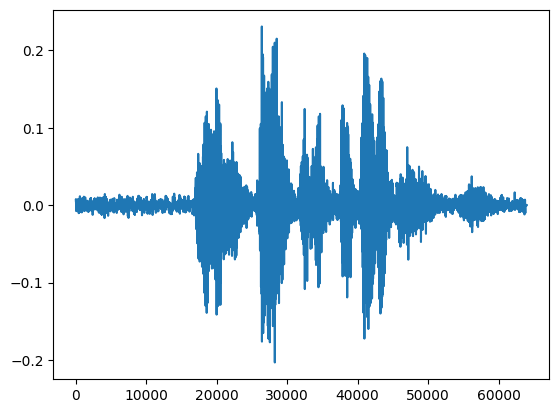

In [7]:
input_audio = '../data/train/TRAIN_0002.wav'

# display(Audio(input_audio))
y, _ = librosa.load(input_audio)
plt.plot(y)

In [17]:
from augly.audio.utils import validate_and_load_audio

input_audio_arr, sr = validate_and_load_audio(input_audio)

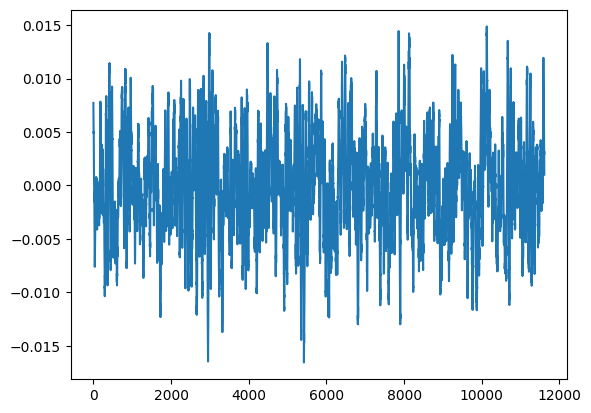

In [67]:
aug = audaugs.Compose([
    audaugs.AddBackgroundNoise(p = 0.1),
    audaugs.Clip(duration_factor = 0.7),
#    audaugs.TimeStretch(rate = 3.0),
#    audaugs.Speed(factor = 3.0),
    audaugs.Harmonic(p = 0.5),
    audaugs.InvertChannels(),
    audaugs.OneOf([audaugs.Clicks(p = 0.6),
                   audaugs.InsertInBackground(offset_factor = 0.25, p = 0.6)
                   ])
#    audaugs.ToMono()
])

aug_audio, _ = aug(input_audio_arr, sample_rate = sr, metadata = [])
plt.plot(aug_audio)

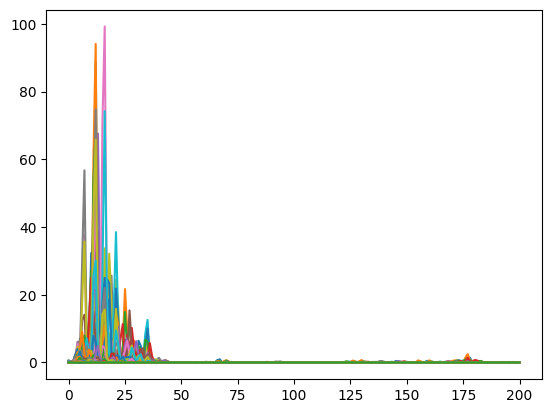

In [73]:
spectrogram = torchaudio.transforms.Spectrogram()

masking = torchaudio.transforms.FrequencyMasking(freq_mask_param = 80)
waveform = torch.Tensor(input_audio_arr)
original = spectrogram(waveform)
masked = masking(original)

plt.plot(original)

NameError: name 'spec_12' is not defined

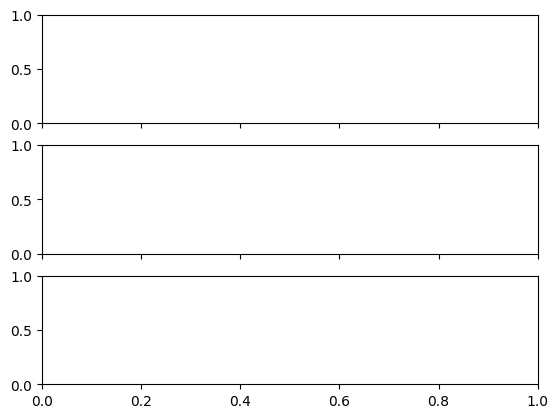

In [74]:
def plot():
    def plot_spec(ax, spec, title):
        ax.set_title(title)
        ax.imshow(librosa.amplitude_to_db(spec), origin="lower", aspect="auto")

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
    plot_spec(axes[0], torch.abs(spec_12[0]), title="Stretched x1.2")
    plot_spec(axes[1], torch.abs(spec[0]), title="Original")
    plot_spec(axes[2], torch.abs(spec_09[0]), title="Stretched x0.9")
    fig.tight_layout()


plot()

In [3]:
### AUGMENTATION PRACTICE ###

In [2]:
class config:
    seed = 42
    num_fold = 1
    sample_rate = 16000
    n_fft = 1024
    hop_length = 512
    n_mels = 64
    duration = 5
    num_classes = 6
    train_batch_size = 128
    valid_batch_size = 128
    model_name = 'efficientnet_v2_l'
    epochs = 20
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-7

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(config.seed)

In [4]:
df = pd.read_csv("/scratch/network/mk8574/audio_sentiment_challenge/data/train.csv")
df.head()

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4


In [5]:
signal, sr = torchaudio.load('/scratch/network/mk8574/audio_sentiment_challenge/data/train/TRAIN_0001.wav')
print(signal.shape)
print(sr)

torch.Size([1, 41642])
16000


In [6]:
class AudioSentDataset(Dataset):
    def __init__(self, df, transformation, target_sample_rate, duration, mode):
        self.audio_paths = df['path'].values
        if mode != 'test':
            self.labels = df['label'].values
        self.transformation = transformation # transformation
        self.target_sample_rate = target_sample_rate # sample rate
        self.num_samples = target_sample_rate * duration
        self.mode = mode # ['train', 'valid', 'test']
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = os.path.join('/scratch/network/mk8574/audio_sentiment_challenge/data', self.audio_paths[index])

        signal, sr = torchaudio.load(audio_path) # loaded the audio
        
        # Now we first checked if the sample rate is same as TARGET_SAMPLE_RATE and if it not equal we perform resampling
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        
        # IN CASE DATA IS STEREO:
        # Next we check the number of channels of the signal
        #signal -> (num_channels, num_samples) - Eg.-(2, 14000) -> (1, 14000)
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        

        # Lastly we check the number of samples of the signal
        #signal -> (num_channels, num_samples) - Eg.-(1, 14000) -> (1, self.num_samples)
        # If it is more than the required number of samples, we truncate the signal
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        # If it is less than the required number of samples, we pad the signal
        if signal.shape[1]<self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
        # Finally all the process has been done and now we will extract mel spectrogram from the signal
        mel = self.transformation(signal)
        
        # For pretrained models, we need 3 channel image, so for that we concatenate the extracted mel
        image = torch.cat([mel, mel, mel])
        
        # Normalize the image
        max_val = torch.abs(image).max()
        image = image / max_val
        
        
        if self.mode in ['train', 'valid']:
            label = torch.tensor(self.labels[index])
        
            return image, label
        
        else:
            return image

In [7]:
from sklearn.model_selection import train_test_split

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)

mfcc = torchaudio.transforms.MFCC(sample_rate = config.sample_rate,
                                 n_mfcc = 20,
                                 log_mels = False)

# Function to get data according to the folds
def get_data():
    df = pd.read_csv('/scratch/network/mk8574/audio_sentiment_challenge/data/train.csv')
    train_df, valid_df = train_test_split(df, test_size = 0.2, shuffle = True)
    
    train_dataset = AudioSentDataset(train_df, mfcc, config.sample_rate, config.duration, mode = 'train')
    valid_dataset = AudioSentDataset(valid_df, mfcc, config.sample_rate, config.duration, mode = 'valid')
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=True)
    
    return train_loader, valid_loader

In [8]:
class BirdCLEFResnet(nn.Module):
    def __init__(self):
        super(BirdCLEFResnet, self).__init__()
        self.base_model = models.__getattribute__(config.model_name)(pretrained=True)
        # for param in self.base_model.parameters():
        #     param.requires_grad = False

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p = 0.4, inplace = True),
            nn.Linear(in_features = 1280, out_features = 6, bias = True)
        )
        
        torch.nn.init.xavier_normal_(self.base_model.classifier[1].weight.data)

#         in_features = self.base_model.fc.in_features
        
#         self.base_model.fc = nn.Linear(in_features, config.num_classes)
#         torch.nn.init.xavier_normal_(self.base_model.fc.weight.data)

#         (classifier): Sequential(
    #   (0): Dropout(p=0.4, inplace=True)
    #   (1): Linear(in_features=1280, out_features=1000, bias=True)
    # )

    def forward(self, x):
        x = self.base_model(x)
        return x

In [ ]:
BirdCLEFResnet()

In [10]:
from torch import autograd
autograd.set_detect_anomaly(True)

In [11]:
def loss_fn(outputs, labels):
    SMOOTH = 1e-10
    
    return nn.CrossEntropyLoss(label_smoothing = 0.3)(outputs + SMOOTH, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        # print(mels.shape)
        # print('-' * 60)
        # print(labels.shape)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss / len(data_loader)

In [12]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        # print('Outputs:', outputs)
        # print('Labels:', labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    label = torch.Tensor(label)
    pred = torch.Tensor(pred)
    valid_acc = (label == pred).float().sum() / label.shape[0]
    
    return running_loss/len(data_loader), valid_f1, valid_acc

In [13]:
a = torch.Tensor([1, 2, 3])
b = torch.Tensor([1, 4, 5])

print((a == b).float().sum())

tensor(1.)


In [14]:
def run():
    train_loader, valid_loader = get_data()
    
    model = BirdCLEFResnet().to(config.device)
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1, valid_acc = valid(model, valid_loader, config.device, epoch)
        
        print(f"Validation F1 - {valid_f1}, Accuracy - {valid_acc}")
        torch.save(model.state_dict(), f'./model_{epoch}.bin')
        print(f"Saved model checkpoint at ./model_{epoch}.bin")

    return best_valid_f1

In [15]:
# run()

In [66]:
def predict():
    PATH = "./model_19.bin"
    
    test_df = pd.read_csv('../data/test.csv')
    
    model = BirdCLEFResnet().to(config.device)
    
    model.load_state_dict(torch.load(PATH))
    
    test_dataset = AudioSentDataset(test_df, mfcc, config.sample_rate, config.duration, mode = 'test')
    test_loader = DataLoader(test_dataset, batch_size=30, shuffle = False)
    test_df = test_df.drop(['path'], axis = 1)

    ans = []
    for i, mels in enumerate(tqdm(test_loader, position=0)):   
        mels = mels.to(config.device)

        mels = torch.argmax(model(mels), dim = 1)
        
        ans.append(mels)
    
    z = [y.item() for x in ans for y in x]

    test_df['label'] = z
    test_df.to_csv('submission.csv', index = False)
    
    print(test_df)
    
    return

In [67]:
predict()

100%|██████████| 63/63 [00:45<00:00,  1.38it/s]

             id  label
0     TEST_0000      4
1     TEST_0001      1
2     TEST_0002      3
3     TEST_0003      1
4     TEST_0004      1
...         ...    ...
1876  TEST_1876      4
1877  TEST_1877      1
1878  TEST_1878      1
1879  TEST_1879      1
1880  TEST_1880      5

[1881 rows x 2 columns]
